In [1]:
import math
import os
import anndata
import pickle
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from itertools import groupby
from matplotlib import gridspec
from collections import Counter
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
data_dir = "/projects/b1038/Pulmonary/cpuritz/PASC/data"

In [3]:
adata = sc.read_h5ad(f"{data_dir}/01BAL/integrated_BAL/integrated_BAL.h5ad")

## Small heatmap of factors

In [4]:
def get_factor_celltypes(adata, obs_key):
    cell_scores_df = pd.DataFrame(adata.obsm['SPECTRA_cell_scores'])
    cell_scores_df['celltype'] = list(adata.obs[obs_key])
    
    global_factors_series = (cell_scores_df.groupby('celltype').mean() != 0).all()
    global_factors = [factor for factor in global_factors_series.index if global_factors_series[factor]]
    specific_cell_scores = (cell_scores_df.groupby('celltype').mean()).T[~global_factors_series].T
    specific_factors = {}
    
    for i in set(cell_scores_df['celltype']):
        specific_factors[i] = [factor for factor in specific_cell_scores.loc[i].index if
                               specific_cell_scores.loc[i, factor]]
    
    factors_inv = {}
    for i,v in specific_factors.items():
        for factor in v:
            factors_inv[factor] = i
    
    for factor in global_factors:
        factors_inv[factor] = 'global'
            
    return factors_inv

In [5]:
factor_celltypes = get_factor_celltypes(adata, 'cell_type_spectra')

# Obtain cell scores
cell_scores = pd.DataFrame(
    adata.obsm['SPECTRA_cell_scores'], 
    index = adata.obs_names,
    columns = [f"{factor_celltypes[x]}_{x}" for x in range(adata.uns['SPECTRA_factors'].shape[0])]
)

# Map pathway names to factor names
with open(f"{data_dir}/01BAL/spectra/orig_factor_names_map.pkl", 'rb') as f:
    orig_factor_names_map = pickle.load(f)
factor_names_map = {k: ''.join(v.split('_')[:2]) for k, v in orig_factor_names_map.items()}
cell_scores.columns = pd.Index([factor_names_map[x] for x in cell_scores.columns])

In [6]:
# Add metadata to cell scores
cell_scores["Status"] = adata.obs.is_RPRA.astype(str).map({'True': 'RPRA', 'False': 'Healthy'})
cell_scores["Study_ID"] = adata.obs.Study_ID.astype(str)
cell_scores["cell_type"] = adata.obs.cell_type.astype(str)

In [7]:
# Set scores less than threshold to zero
nf = len(factor_names_map)
cs_threshold = 0.001
cell_scores.iloc[:, 0:nf] = cell_scores.iloc[:, 0:nf].applymap(lambda x: 0 if x < cs_threshold else x)

# Compute subject scores as mean of positive cells
res = []
unique_pairs = cell_scores[['Study_ID', 'cell_type']].drop_duplicates()
for _, x in unique_pairs.iterrows():
    scores_sub = cell_scores[(cell_scores.Study_ID == x["Study_ID"]) & (cell_scores.cell_type == x["cell_type"])]
    # Mean cell score across cells with positive scores
    means = scores_sub.iloc[:, 0:nf].apply(lambda c: np.mean(c[c > 0]) if np.sum(c > 0) else 0)
    # Number of cells in total
    ncell = scores_sub.shape[0]
    # Percent of cells with positive scores for each factor
    ppos = scores_sub.iloc[:, 0:nf].apply(lambda c: np.sum(c > 0) / ncell)
    # For factors that are positive across less than 10% of cells, set score to 0
    means[ppos < 0.10] = 0
    # Add metadata
    means = means.append(scores_sub.iloc[0, nf:(nf + 3)])
    means["n_cell"] = ncell
    res.append(means)
res = pd.DataFrame(res)
# Reorder columns
subject_scores = res[['Study_ID', 'cell_type', 'Status', 'n_cell'] + res.columns.tolist()[:-4]]

In [8]:
# Compute subject scores as mean cell score
subject_scores = cell_scores.groupby(['Study_ID', 'cell_type', 'Status']).agg(['mean', 'count']).reset_index()

# Record number of cells for each subject/cell type combination
count_cols = subject_scores.columns.get_level_values(1) == 'count'
counts = subject_scores.iloc[:, count_cols].iloc[:, [0]].droplevel(1, axis = 1)
subject_scores = subject_scores.iloc[:, ~count_cols].droplevel(1, axis = 1)
subject_scores.insert(3, 'n_cell', counts)

In [9]:
def get_ct_score(cell_type):
    ct_scores = subject_scores.loc[subject_scores.cell_type == cell_type].copy()
    # Require a minimum of 10 cells
    ct_scores = ct_scores[ct_scores.n_cell >= 10]
    return ct_scores

In [10]:
cell_types = ["Monocytes-1", "Monocytes-2", "MoAM-1", "MoAM-2", "MoAM-3", "MoAM-4", "TRAM-1", "TRAM-2", "TRAM-3",
              "TRAM-4", "TRAM-5", "TRAM-6", "TRAM-7", "Proliferating macrophages", "Perivascular macrophages"]

In [11]:
all_scores = get_ct_score(cell_types[0])
for ct in cell_types[1:]:
    all_scores = pd.concat([all_scores, get_ct_score(ct)])
all_scores = all_scores.reset_index(drop = True)

In [12]:
all_scores.cell_type = pd.Categorical(all_scores.cell_type)
all_scores.cell_type = all_scores.cell_type.cat.set_categories(cell_types, ordered = True)
all_scores.Status = pd.Categorical(all_scores.Status)
all_scores.Status = all_scores.Status.cat.set_categories(["Healthy", "RPRA"], ordered = True)
all_scores = all_scores.sort_values(by = ['cell_type', 'Status'])

In [13]:
sorted_scores = all_scores.set_index(['cell_type', 'Status']).drop(columns = ["Study_ID", "n_cell"])

In [14]:
# Standard score
sorted_scores = sorted_scores.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [15]:
# Subset factors
factors = ["F13", "F18", "F31", "F28", "F42", "F17", "F30", "F9", "F0", "F46", "F32", "F2", "F37", "F33", "F36",
           "F5", "F15", "F43", "F38", "F25", "F6", "F12", "F8"]
sorted_scores = sorted_scores[factors]

In [16]:
status = sorted_scores.index.get_level_values(1).tolist()

In [17]:
sorted_scores = sorted_scores.reset_index(level = 1, drop = True)
sorted_scores.index = sorted_scores.index.str.replace('macrophages', 'MP')
sorted_scores.index = sorted_scores.index.str.replace('Monocytes-1', 'Mo-1')

In [18]:
color_map = {"RPRA": (1, 0, 0), "Healthy": (0, 0, 1)}
status_colors = [color_map[element] for element in status]

In [19]:
# Create figure
fig = plt.figure(figsize = (27, 12))
ax = fig.add_subplot()

# Create heatmap
sns.heatmap(sorted_scores.T, cbar_kws = {"shrink": 0.3, "pad": 0.015}, yticklabels = 1, linecolor = 'black')
ax.set_xlabel('')
ax.set_xticklabels([''] * len(ax.get_xticklabels()))
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
ax.tick_params(axis = 'x', which = 'both', bottom = False)
ax.tick_params(axis = 'y', labelsize = 10)

# Color palette for cell types
cell_names = sorted_scores.index.unique().tolist()
palette = sns.color_palette("muted")
colors = []
for i in range(int(np.ceil(len(cell_names) / len(palette)))):
    colors += palette
    
# Adjust limits to add column annotations
lw1 = 0.6
lw2 = 0.3
ax.set_ylim((ax.get_ylim()[0], ax.get_ylim()[1] - lw1 - lw2))
    
# Cell type annotations
x = 0
offset = [11.1, -1.9, -1, -1, -1, 0, 1.2, 1.2, -1, 1, -1, 0, -1, -7, -7.1]
for i in range(len(cell_names)):
    nc = np.sum(sorted_scores.index == cell_names[i])
    ax.add_patch(patches.Rectangle((x, -lw1 - lw2), nc, lw1, edgecolor = 'k', facecolor = colors[i]))
    ax.text(x + nc + offset[i] - 20, -0.5, cell_names[i], size = 10)
    x += nc

# Status annotations
for i in range(len(sorted_scores)):
    c = status_colors[i]
    ax.add_patch(patches.Rectangle((i + 0.161, -lw2 + 0.03), 1, lw2 - 0.03, edgecolor = c, facecolor = c))

# Status annotation legend
ax.legend(handles = [patches.Patch(color = 'red', label = 'RPRA'),
                     patches.Patch(color = 'blue', label = 'Healthy')],
          loc = 'upper left', bbox_to_anchor = (1, 0.983))
ax.collections[0].colorbar.set_label('Row standard score')

plt.savefig(f"{data_dir}/figures/fig_4/fig_4a_new.pdf", bbox_inches = 'tight', transparent = True)
plt.close()

## Heatmap of genes in fibrotic program

In [24]:
fibrotic_genes = pd.read_csv(f"{data_dir}/01BAL/spectra/Spectra_F0_F9_F17_clean.csv", header = None)[0]

In [25]:
adata_mt = adata[[x[0:4] in ["TRAM", "MoAM"] for x in adata.obs.cell_type]].copy()
raw_counts = pd.DataFrame(adata_mt.layers["counts"].todense(),
                          index = adata_mt.obs_names,
                          columns = adata_mt.var_names)
raw_counts = raw_counts.loc[:, fibrotic_genes]

In [26]:
# Pseudobulk counts
pb_counts = raw_counts.groupby([adata_mt.obs["cell_type"], adata_mt.obs["Study_ID"]]).agg(['sum', 'size'])
# Require minimum of 10 cells
pb_counts = pb_counts[pb_counts[pb_counts.columns[1]] >= 10]
# Remove size columns
pb_counts = pb_counts[[col for col in pb_counts.columns if col[1] != 'size']]
# Flatten columns
pb_counts.columns = [c[0] for c in pb_counts.columns]

In [27]:
# Flatten index
pb_counts.index = ['_'.join(map(str, idx)) for idx in pb_counts.index]
# Add cell type and Study ID to each row
pb_counts["cell_type"] = [x.split('_')[0] for x in pb_counts.index]
pb_counts["Status"] = ["Healthy" if (x.split('_')[1][0:2] == "HV") else "RPRA" for x in pb_counts.index]

In [28]:
# Order cell types and statuses
cell_types = ['MoAM-1', 'MoAM-2', 'MoAM-3', 'MoAM-4',
              'TRAM-1', 'TRAM-2', 'TRAM-3', 'TRAM-4', 'TRAM-5', 'TRAM-6', 'TRAM-7']
pb_counts.cell_type = pd.Categorical(pb_counts.cell_type)
pb_counts.cell_type = pb_counts.cell_type.cat.set_categories(cell_types, ordered = True)

pb_counts.Status = pd.Categorical(pb_counts.Status)
pb_counts.Status = pb_counts.Status.cat.set_categories(["Healthy", "RPRA"], ordered = True)

pb_counts = pb_counts.sort_values(by = ['cell_type', 'Status'])
pb_counts = pb_counts.set_index(['cell_type', 'Status'])

In [29]:
# Normalize counts
counts_per_sample = 1 + pb_counts.sum(axis = 1)
normalized_counts = np.log1p((pb_counts.T / counts_per_sample).T * 10000)

In [30]:
# Standard score expression for each gene
normalized_counts = normalized_counts.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [31]:
# Record metadata
cell_type_count = Counter(normalized_counts.index.get_level_values(0).tolist())
status = normalized_counts.index.get_level_values(1).tolist()
normalized_counts = normalized_counts.reset_index(level = 1, drop = True)
color_map = {"RPRA": (1, 0, 0), "Healthy": (0, 0, 1)}
status_colors = [color_map[element] for element in status]

In [32]:
# Hierarchical clustering of genes
mat = normalized_counts.T
row_linkage = linkage(mat, method = 'ward')
row_order = dendrogram(row_linkage, no_plot = True)['leaves']
mat = mat.iloc[row_order, :]

## Heatmap of fibrotic genes

In [34]:
factor_celltypes = get_factor_celltypes(adata, 'cell_type_spectra')

# Obtain gene weights
gene_weights = pd.DataFrame(
    adata.uns['SPECTRA_factors'], 
    index = [f"F{x}" for x in range(adata.uns['SPECTRA_factors'].shape[0])],
    columns = adata.var[adata.var['spectra_vocab']].index
).T

In [35]:
F0 = gene_weights["F0"].sort_values(inplace = False, ascending = False)
F9 = gene_weights["F9"].sort_values(inplace = False, ascending = False)
F43 = gene_weights["F43"].sort_values(inplace = False, ascending = False)
F5 = gene_weights["F5"].sort_values(inplace = False, ascending = False)

In [36]:
threshold = 0.0002
F0 = F0[F0 >= threshold]
F9 = F9[F9 >= threshold]
F43 = F43[F43 >= threshold]
F5 = F5[F5 >= threshold]

all_genes = pd.DataFrame({
    'Value': pd.concat([F0, F9, F43, F5]),
    'Factor': ['F0']*len(F0) + ['F9']*len(F9) + ['F43']*len(F43) + ['F5']*len(F5)
})

In [37]:
cell_types = ["Monocytes-1", "Monocytes-2", "MoAM-1", "MoAM-2", "MoAM-3", "MoAM-4", "TRAM-1", "TRAM-2", "TRAM-3",
              "TRAM-4", "TRAM-5", "TRAM-6", "TRAM-7", "Proliferating macrophages", "Perivascular macrophages"]
adata_sub = adata[[x in cell_types for x in adata.obs.cell_type]].copy()
raw_counts = pd.DataFrame(adata_sub.layers["counts"].todense(),
                          index = adata_sub.obs_names,
                          columns = adata_sub.var_names)
raw_counts = raw_counts.loc[:, np.unique(all_genes.index)]

In [38]:
# Pseudobulk counts
pb_counts = raw_counts.groupby([adata_sub.obs["cell_type"], adata_sub.obs["Study_ID"]]).agg(['sum', 'size'])
# Require minimum of 10 cells
pb_counts = pb_counts[pb_counts[pb_counts.columns[1]] >= 10]
# Remove size columns
pb_counts = pb_counts[[col for col in pb_counts.columns if col[1] != 'size']]
# Flatten columns
pb_counts.columns = [c[0] for c in pb_counts.columns]

In [39]:
# Flatten index
pb_counts.index = ['_'.join(map(str, idx)) for idx in pb_counts.index]
# Add cell type and Study ID to each row
pb_counts["cell_type"] = [x.split('_')[0] for x in pb_counts.index]
pb_counts["Status"] = ["Healthy" if (x.split('_')[1][0:2] == "HV") else "RPRA" for x in pb_counts.index]

In [40]:
# Order cell types and statuses
pb_counts.cell_type = pd.Categorical(pb_counts.cell_type)
pb_counts.cell_type = pb_counts.cell_type.cat.set_categories(cell_types, ordered = True)

pb_counts.Status = pd.Categorical(pb_counts.Status)
pb_counts.Status = pb_counts.Status.cat.set_categories(["Healthy", "RPRA"], ordered = True)

pb_counts = pb_counts.sort_values(by = ['cell_type', 'Status'])
pb_counts = pb_counts.set_index(['cell_type', 'Status'])

In [41]:
# Normalize counts
counts_per_sample = 1 + pb_counts.sum(axis = 1)
normalized_counts = np.log1p((pb_counts.T / counts_per_sample).T * 10000)

In [42]:
# Standard score expression for each gene
normalized_counts = normalized_counts.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [43]:
# Record metadata
cell_type_count = Counter(normalized_counts.index.get_level_values(0).tolist())
status = normalized_counts.index.get_level_values(1).tolist()
normalized_counts = normalized_counts.reset_index(level = 1, drop = True)
color_map = {"RPRA": (1, 0, 0), "Healthy": (0, 0, 1)}
status_colors = [color_map[element] for element in status]

/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


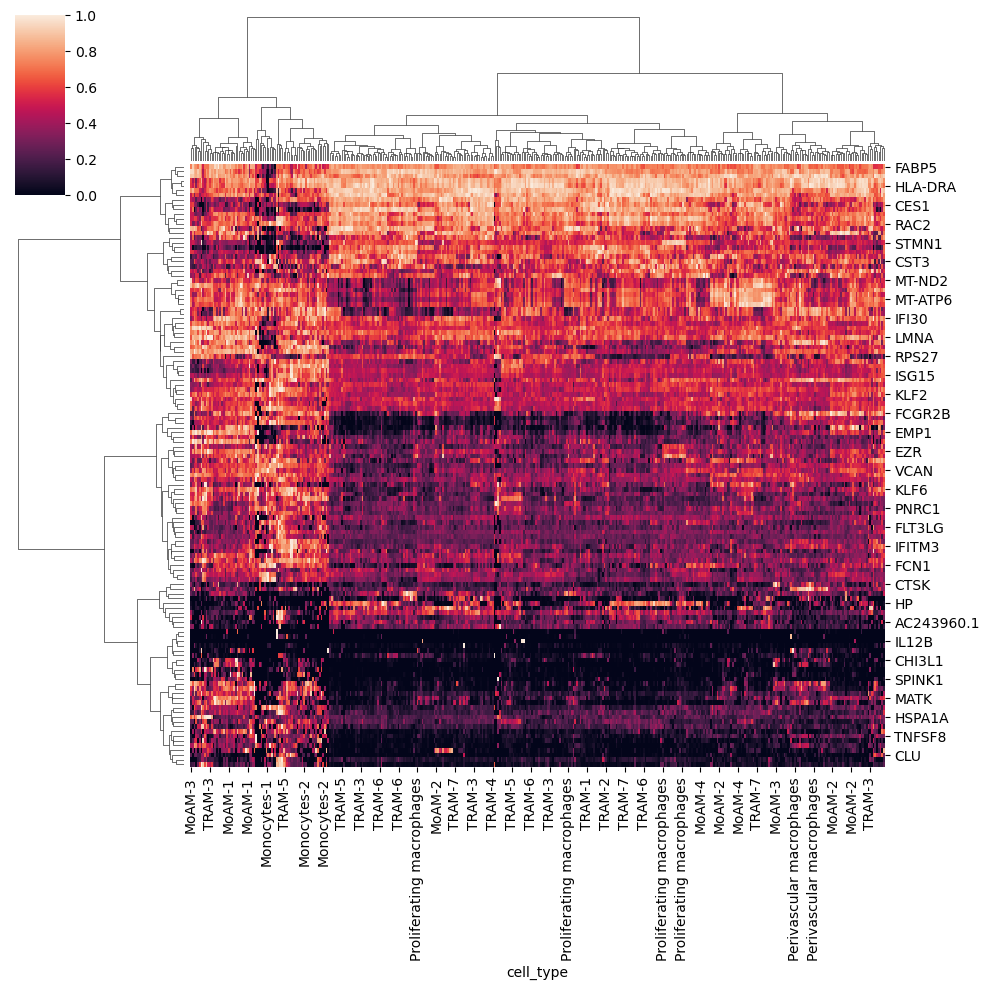

In [44]:
# Hierarchical clustering of genes
mat = normalized_counts.T
g = sns.clustermap(mat, method = 'ward')
row_linkage = g.dendrogram_row.linkage
row_order = g.dendrogram_row.reordered_ind
mat = mat.iloc[row_order[::-1], :]

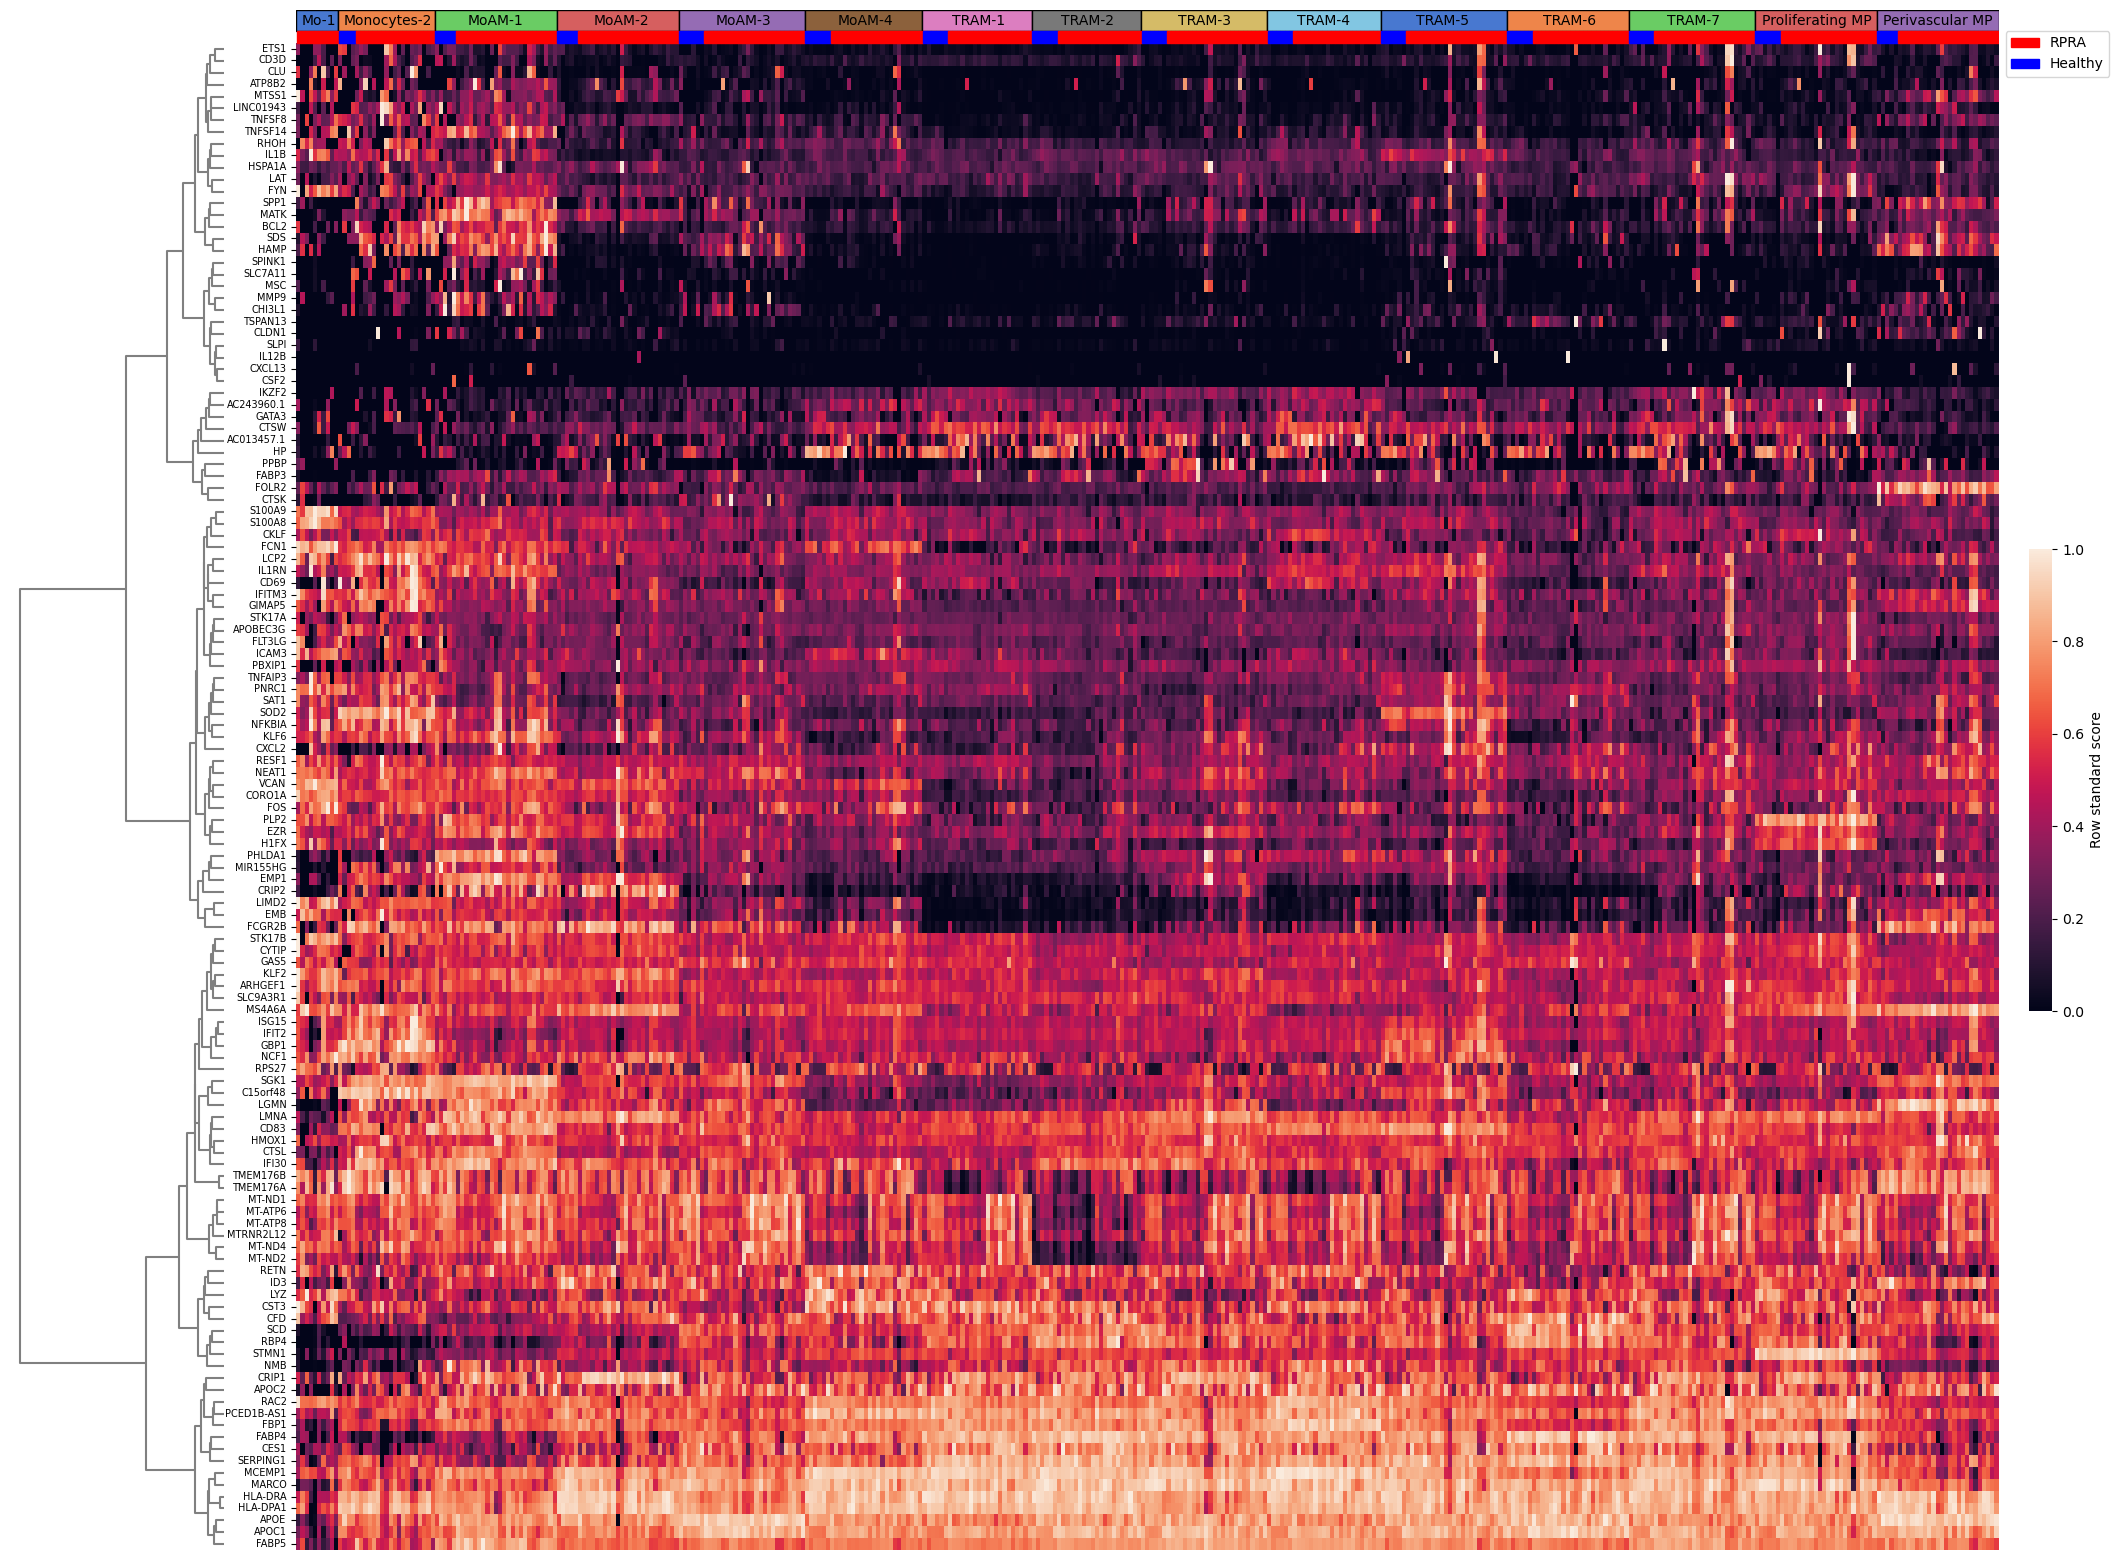

In [45]:
# Create figure
fig = plt.figure(figsize = (30, 20))
gs = gridspec.GridSpec(1, 2, width_ratios = [1.05, 10], wspace = 0.064)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

ax0.invert_yaxis()

# Create heatmap
sns.heatmap(mat, cbar_kws = {"shrink": 0.3, "pad": 0.015}, linecolor = 'black',
            xticklabels = False, yticklabels = True, ax = ax1)
ax1.collections[0].colorbar.set_label('Row standard score')
ax1.set_xlabel('')
ax1.tick_params(axis = 'x', which = 'both', bottom = False)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize = 7)

# Create dendrogram
dendro = dendrogram(row_linkage, orientation = 'left', ax = ax0, above_threshold_color = 'gray',
                    color_threshold = 0)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_visible(False)
ax0.spines['bottom'].set_visible(False)

# Cell type color palette
palette = sns.color_palette("muted")
colors = []
for i in range(int(np.ceil(len(cell_types) / len(palette)))):
    colors += palette
    
# Adjust limits to add column annotations
lw1 = 1.75
lw2 = 1
ax0.set_ylim((ax0.get_ylim()[0], ax0.get_ylim()[1] + 28))
ax1.set_ylim((ax1.get_ylim()[0], ax1.get_ylim()[1] - lw1 - lw2))
    
# Cell type annotations
cell_type_pretty = cell_types.copy()
cell_type_pretty[0] = "Mo-1"
cell_type_pretty = [x.replace('macrophages', 'MP') for x in cell_type_pretty]
x = 0
offset = [-7.75, -7.6, -1.1, -0.2, -0.2, -1.2, -2, -2, -0.2, -2, -0.5, -0.5, 0, -7.4, -7.5]
for i in range(len(cell_types)):
    nc = cell_type_count[cell_types[i]]
    ax1.add_patch(patches.Rectangle((x, -lw1 - lw2), nc, lw1, edgecolor = 'k', facecolor = colors[i]))
    ax1.text(x + 9 + offset[i], -1.485, cell_type_pretty[i], size = 10)
    x += nc
    
# Status annotations
for i in range(len(normalized_counts)):
    c = status_colors[i]
    ax1.add_patch(patches.Rectangle((i + 0.13, -lw2 + 0.05), 1, 0.95, edgecolor = c, facecolor = c))
    
ax1.legend(handles = [patches.Patch(color = 'red', label = 'RPRA'),
                      patches.Patch(color = 'blue', label = 'Healthy')],
          loc = 'upper left', bbox_to_anchor = (1, 0.991))
plt.savefig(f"{data_dir}/figures/fig_4/fibrotic_heatmap.pdf", bbox_inches = 'tight', transparent = True)

In [46]:
all_genes.to_csv(f"{data_dir}/01BAL/spectra/heatmap_genes.csv", index = True)